# Analyze A/B Test Results 



- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Summary](#Summary)
- [Conclusion](#conclusion)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, we will be working to understand the results of an A/B test run by an e-commerce website. 

The goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage




<a id='probability'></a>
## Part I - Probability



Adding borders to any table we make :

In [1]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 1px  black solid !important;
  color: black !important;
}
</style>

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
# setting up the seed so you can get same notebooks results
random.seed(42)

### Part I.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>





**a.** Reading the dataset from the `ab_data.csv` 

In [3]:
#Reading the data set .
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** The number of rows in the dataset.

In [4]:
df.shape[0]

294478

**c.** The number of unique users in the dataset.

In [5]:
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

**d.** The proportion of users converted.

In [6]:
pd.crosstab(df.user_id.count(),df.converted,normalize='index')

converted,0,1
row_0,,
294478,0.880341,0.119659


In [7]:
df.converted.mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [8]:
pd.crosstab(df.group,df.landing_page)

landing_page,new_page,old_page
group,,
control,1928,145274
treatment,145311,1965


**From the above table, we can see that there is 1928 user in the control group who see the new page which is not what we want and there is 1965 user in the treatment group who see the old page which is also not what we want.**

**So there is 3893 user who sees the wrong page for our test.**

**f.** checking the missing values.

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [10]:
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

**g.** Checking if our data set has duplicated rows.

In [11]:
df.duplicated().sum()

0

### Part I.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  






In [12]:
# Remove the inaccurate rows, and store the result in a new dataframe df2
df_treatment = df.query('group == "treatment" and landing_page == "new_page"')
df_control =df.query('group == "control" and landing_page == "old_page"')
df2 =pd.concat([df_treatment, df_control]) 
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [13]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

In [14]:
pd.crosstab(df2.group,df2.landing_page)

landing_page,new_page,old_page
group,,
control,0,145274
treatment,145311,0


### Part I.3  


**a.** The unique numbers of **user_id**

In [15]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

**b.** The repeated  **user_id** in **df2**.  

In [16]:
duplicate = df2.user_id[df2.user_id.duplicated(keep=False)]
duplicate

1899    773192
2893    773192
Name: user_id, dtype: int64

**c.** checking the rows for the duplicate **user_id**

In [17]:
df2.query('user_id ==773192 ')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [18]:
# Remove one of the rows with a duplicate user_id.
"""
Hint:The df.drop_duplicates()may not work in this case because the rows with duplicate user_id are not entirely identical.

"""
df2.drop(index=2893, inplace = True)

# Check again if the row with a duplicate user_id is deleted or not
df2.query('user_id ==773192')

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0


### Part I.4  


**a.** The probability of an individual converting regardless of the page they receive .<br><br>




In [19]:
p_population = pd.crosstab(df2.user_id.count(),df2.converted,normalize='index')*100
p_population

converted,0,1
row_0,,
290584,88.040291,11.959709


In [20]:
df.converted.mean()

0.11965919355605512

**b.** The probability of an individual converted given that he was in the `control` group.

In [21]:
p_population_c_t =pd.crosstab(df2.group,df2.converted,normalize='index')*100
p_population_c_t

converted,0,1
group,,
control,87.961370,12.038630
treatment,88.119193,11.880807


In [22]:
Control_df = df2.query('group == "control"').converted.mean()
Control_df

0.1203863045004612

**c.** The probability of an individual converted given that he was in the `treatment` group.

In [23]:
treatment_df = df2.query('group == "treatment"').converted.mean()
treatment_df

0.11880806551510564

In [24]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = treatment_df - Control_df
obs_diff 

-0.0015782389853555567

**d.** The probability of  an individual received the old page vs the new page.

In [25]:
pd.crosstab(df2.user_id.count(),df2.landing_page,normalize='index')

landing_page,new_page,old_page
row_0,,
290584,0.500062,0.499938


**Based on the results from section (1.4):**

- **The probability of the conversion rate from the control group was 12.03 %  which is slightly higher than the conversion rate from the treatment which was 11.88 %.**


- **The probability of showing the 2 pages was almost fair.**


- **But those statistics were from the observation sample which didn't mean it is statistically significant.
    that didn't mean it is statistically significant.**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### Part II.1
For now, consider we need to make the decision just based on all the data provided.  

> Recall that we just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (section 1.4). 

**If we want to assume that the old page is better unless the new page proves to be better at a Type I error rate of 5%, that will go as the following:**



$$H_0: P_{new} \leq  P_{pld} $$

$$H_1:P_{new} > P_{old} $$

$$or$$

$$H_0:  P_{new} -  P_{old} \leq  0$$

$$H_1: P_{new} -  P_{old} >  0$$


### Part II.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, we will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



**a.** The **conversion rate** for $p_{new}$ under the null hypothesis.

In [26]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

**b.** The **conversion rate** for $p_{old}$ under the null hypothesis .

In [27]:
p_old =df2.converted.mean()
p_old 

0.11959708724499628

**c.**The number of individuals in the treatment group . <br><br>
*Hint*: The treatment group users are shown the new page.

In [28]:
n_new = len(df2.query('group == "treatment"'))
n_new

145310

**d.** The number of individuals in the control group .

In [29]:
n_old = len(df2.query('group == "control"'))
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [30]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], size=n_new, p=[p_new, (1-p_new)])
new_page_converted.mean()

0.88013213130548484

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> 

In [31]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size=n_old, p=[p_old, (1-p_old)])
old_page_converted.mean()

0.88149978661012984

**g.** The difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ in simulated samples from the parts (e) and (f) above. 

In [32]:
new_page_converted.mean() - old_page_converted.mean()

-0.0013676553046449991


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and finding the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above this is also knowing as bootstrapping method .



In [33]:
# Sampling distribution 
p_diffs = []
for i in range (10000):
    Bootstrapping_new_page_converted =np.random.choice([0, 1], size=n_new, p=[p_new, (1-p_new)]).mean()
    Bootstrapping_old_page_converted =np.random.choice([0, 1], size=n_old, p=[p_old, (1-p_old)]).mean()
    diffs=(Bootstrapping_new_page_converted - Bootstrapping_old_page_converted)
    # adding to p_diffs
    p_diffs.append(diffs)

**i. Histogram**<br> 
Ploting a histogram of the **p_diffs**. 



In [34]:
# Convert to numpy array
p_diffs = np.array(p_diffs)

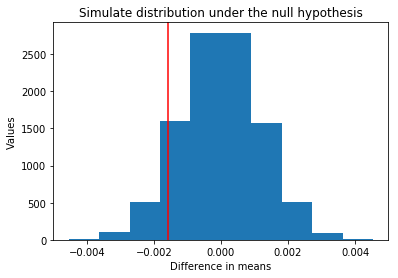

In [35]:
# Simulate distribution under the null hypothesis
null_vals = np.random.normal(0, p_diffs.std(), p_diffs.size)

# Plot the null distribution
plt.hist(null_vals)
plt.title('Simulate distribution under the null hypothesis')
plt.xlabel('Difference in means')
plt.ylabel('Values')
plt.axvline(obs_diff, c='red');

**j.** The proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data .

In [36]:
# Compute p-value
p_value=(p_diffs > obs_diff).mean()
p_value

0.90259999999999996

**Based on the results from section (2.2) :**

- **In part J we Compute the p-value, in statistics the definition of  p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null  hypothesis is true.**


- **Applying this to our case we can see that The proportion of the p_diffs(the difference in means ) that are greater than the actual difference in means in our observed sample is 90 %**


- **P($ ( p{'}_{new} - p{'}_{old} )> (P_{new} -  P_{old} ) |  H_0$ is ture ) = .90**


- **Having our Type I error rate as 0.05 we can see that the p-value is greater than the Type I error threshold as that means we fail to reject the Null Hypothesis $H_0$ which we set at the Part II.1**


- **For more information about p-value please visit [ this article](https://www.investopedia.com/terms/p/p-value.asp#:~:text=A%20p%2Dvalue%20is%20a,confidence%20levels%20for%20hypothesis%20testing.).**


### Part II.3  Z-test :

**a. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 



In [37]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = len(df2.query('landing_page == "old_page" and converted==1')) 
print(f"The number of conversions with the old_page is {convert_old}\n")

# number of conversions with the new_page
convert_new = len(df2.query('landing_page == "new_page" and converted==1')) 
print(f"The number of conversions with the new_page is {convert_new}\n")

# number of individuals who were shown the old_page
print(f"The number of individuals who were shown the old_page is {n_old}\n")

# number of individuals who received new_page
print(f"The number of individuals who received new_page is {n_new}\n")


The number of conversions with the old_page is 17489

The number of conversions with the new_page is 17264

The number of individuals who were shown the old_page is 145274

The number of individuals who received new_page is 145310



/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**b.**  Using `sm.stats.proportions_ztest()` to compute test statistic and p-value.  [Here](https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html) is a helpful link on using the built in.

The syntax is: 
```bash
proportions_ztest(count_array, nobs_array, alternative='larger')
```
where, 
- `count_array` = represents the number of "converted" for each group
- `nobs_array` = represents the total number of observations (rows) in each group
- `alternative` = choose one of the values from `[‘two-sided’, ‘smaller’, ‘larger’]` depending upon two-tailed, left-tailed, or right-tailed respectively. 
>**Hint**: <br>
It's a two-tailed if you defined $H_1$ as $(p_{new} = p_{old})$. <br>
It's a left-tailed if you defined $H_1$ as $(p_{new} < p_{old})$. <br>
It's a right-tailed if you defined $H_1$ as $(p_{new} > p_{old})$. 

The built-in function above will return the z_score, p_value. 

---
### About the two-sample z-test
Recall that you have plotted a distribution `p_diffs` representing the
difference in the "converted" probability  $(p{'}_{new}-p{'}_{old})$  for your two simulated samples 10,000 times. 

Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where,
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


>Z-test is performed when the sample size is large, and the population variance is known. The z-score represents the distance between the two "converted" success rates in terms of the standard error. 

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 
- $Z_{score}$
- $Z_{\alpha}$ or $Z_{0.05}$, also known as critical value at 95% confidence interval.  $Z_{0.05}$ is 1.645 for one-tailed tests,  and 1.960 for two-tailed test. You can determine the $Z_{\alpha}$ from the z-table manually. 

Decide if your hypothesis is either a two-tailed, left-tailed, or right-tailed test. Accordingly, reject OR fail to reject the  null based on the comparison between $Z_{score}$ and $Z_{\alpha}$. We determine whether or not the $Z_{score}$ lies in the "rejection region" in the distribution. In other words, a "rejection region" is an interval where the null hypothesis is rejected iff the $Z_{score}$ lies in that region.

>Hint:<br>
For a right-tailed test, reject null if $Z_{score}$ > $Z_{\alpha}$. <br>
For a left-tailed test, reject null if $Z_{score}$ < $Z_{\alpha}$. 




Reference: 
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy www.stats.libretexts.org

---



In [38]:
import statsmodels.api as sm
from scipy.stats import norm

# Compute z-test
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old] , [n_new,n_old], alternative='larger')
print(f'z_score = {z_score} , p_value= {p_value}\n')

# Compute z-critical:
z_critical = norm.ppf (1- (0.05))
print(f'z-critical = {z_critical }')

z_score = -1.3109241984234394 , p_value= 0.9050583127590245

z-critical = 1.6448536269514722


**Based on the results from section (2.3):**

- **The z-score for the test was -1.31 and z-critical was 1.64 that mean  ($Z_{score}$ < $Z_{\alpha}$) given that our alternative hypothesis is a right-tailed test $H_1$:$(p_{new} > p_{old})$ that tell us we have no proof that the alternative hypothesis is true according to that we fail to reject the null hypothesis $H_0$.**


- **Also, the p-value from the z-test is the same value from bootstrapping method we compute in section (2.2), having our type I error rate as 0.05 we can see that the p-value is greater than the Type I error threshold as that means we fail to reject the Null Hypothesis $H_0$**

<a id='regression'></a>
### Part III - A regression approach

###  Part III.1 
In this final part, we will see that the result we achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 



**a.** Since each row in the `df2` data is either a conversion or no conversion , we will use **logistic regression**

**b.** The goal is to use **statsmodels** library to fit **The logistic regression model** to see if there is a significant difference in conversion based on the page-type a customer receives. However, we first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [39]:
df2.head()

,user_id,timestamp,group,landing_page,converted
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1


In [40]:
df2[['ab_page','nold_page']] = pd.get_dummies(df2['landing_page'])
df2 = df2.drop('nold_page',axis = 1)
df2['intercept'] = 1
df2.head()

,user_id,timestamp,group,landing_page,converted,ab_page,intercept
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


**c.** Using **statsmodels** to instantiate our regression model on the two columns we created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [41]:
log_model = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = log_model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.**  The summary of our model below

In [42]:
results.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-19 23:19 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

In [43]:
np.exp(results.params)[1]

0.98512266403503657

In [44]:
1/np.exp(results.params)[1]

1.0151020136964732

**Based on the results from section (3.1):**

- **we exponentiate the coefficients for ab_page(-0.0150 ) to get the approximate values of 0.98, The result is interpreted as follows:**

 -  1- for each 1 unit increase in ab_page, the conversion rate is .98 times as likely, holding all other variables constant.
  
 -  2- When multiplicative changes are less than 1, like ab_page = .98, it is usually useful to calculate the reciprocal. 
    this changes the direction from a unit increase to a unit decrease. So, the result for ab_page could also be interpreted       as: for every 1 unit decrease in ab_page, the converted rate is 1.015 times as likely, holding all other variables             constant.
  

- **The p-value here is .19 which is still greater than our Type I error threshold (.05), according to that the coefficient is not statistically significant.**


- **The p-value from the regression approach is different from the p-value from hypothesis testing in part II as in  the last one our null and alternative hypotheses model assumed that there is an equal probability of the old and new page converting users,
in the regression approach, we try to see which factor is more correlated on the response value (the predicted value )  which value can predict our response value better 
Also, the Logistic Regression model performs as a two-tailed test but in the  hypothesis Testing in part II perform as a one-tailed test**

- **Although the results above there are other things that might influence whether or not an individual converts such as ideology, age, nationality, or gender, adding additional factors may enhance our results but a disadvantage of multiple factors in a logistic regression model is those results are more complex to interpret.**

###  Part III.2  


**a. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages.

In [45]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [46]:
df_countries.country.value_counts()

US    203619
UK     72466
CA     14499
Name: country, dtype: int64

In [47]:
# Join with the df2 dataframe
df_m =df2.set_index('user_id').join(df_countries.set_index('user_id'), how='inner')
df_m.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country
user_id,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA


In [48]:
# Create the necessary dummy variables
countries =  pd.get_dummies(df_m['country'],drop_first=True)
df_m=pd.concat([df_m, countries],axis=1)
df_m.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US
user_id,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,0


**b. buliding  the  model**<br> 
 we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  


In [49]:
#Create the necessary additional columns
df_m['ab_page_UK'] = df_m['ab_page']*df_m['UK']
df_m['ab_page_US'] = df_m['ab_page']*df_m['US']
df_m.head()

,timestamp,group,landing_page,converted,ab_page,intercept,country,UK,US,ab_page_UK,ab_page_US
user_id,,,,,,,,,,,
661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1,US,0,1,0,1
853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1,US,0,1,0,1
679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1,CA,0,0,0,0
817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1,UK,1,0,1,0
839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1,CA,0,0,0,0


 Calculate the VIFs for each variable in the model.  

In [50]:
# get y and X dataframes based on this regression:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

y, X = dmatrices('converted ~ ab_page + UK + US+ab_page_UK+ab_page_US' , df_m, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,40.370103,Intercept
1,20.042669,ab_page
2,9.052871,UK
3,9.065123,US
4,10.469097,ab_page_UK
5,19.555056,ab_page_US


In [51]:
# comp 1
y, X = dmatrices('converted ~ +ab_page_UK+ab_page_US' , df_m, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,1.904532,Intercept
1,1.082987,ab_page_UK
2,1.082987,ab_page_US


In [52]:
# comp 2
y, X = dmatrices('converted ~ ab_page + UK + US' , df_m, return_type='dataframe')
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif

,VIF Factor,features
0,21.055923,Intercept
1,1.000006,ab_page
2,4.502236,UK
3,4.502223,US


In [53]:
# Fit your model, and summarize the results
log_model2 = sm.Logit(df_m['converted'], df_m[['intercept','ab_page_UK','ab_page_US']])
results = log_model2.fit()
results.summary2()

Optimization terminated successfully.
         Current function value: 0.366117
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-03-19 23:19 AIC:              212781.7674
No. Observations:   290584           BIC:              212813.5064
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9926    0.0079  -252.9104  0.0000  -2.0081  -1.9772
ab_page_UK    0.0112    0.0179     0.6256  0.5316  -0.0240   0.0464
ab_page_US   -0.0144    0.0125    -1.1548  0.2482  -0.0389   0.0101
==================================================================

"""

In [54]:
np.exp(results.params)

intercept     0.136338
ab_page_UK    1.011292
ab_page_US    0.985679
dtype: float64

In [55]:
1/np.exp(results.params)

intercept     7.334699
ab_page_UK    0.988834
ab_page_US    1.014530
dtype: float64

- **According to the p-value from the above summary, we can see that it's higher than our threshold ( .05 ), which means interactions between page and country have no significant effects on conversion.**


- **The company should not waste money and time on the new page because there is no evidence that it is increasing the conversion.** .

<a id='Summary'></a>
## Summary

> ### Part I - Probability
> **Based on the results from section (1.4):**
>- **The probability of the conversion rate from the control group was 12.03 %  which is slightly higher than the conversion rate from the treatment which was 11.88 %.**

>- **The probability of showing the 2 pages was almost fair.**

>- **But those statistics were from the observation sample which didn't mean it is statistically significant.
    that didn't mean it is statistically significant.**
    

> ### Part II - A/B Test
>**Based on the results from section (2.2) :**

>- **In part J we Compute the p-value, in statistics the definition of  p-value is the probability of observing your statistic (or one more extreme in favor of the alternative) if the null  hypothesis is true.**

>- **Applying this to our case we can see that The proportion of the p_diffs(the difference in means ) that are greater than the actual difference in means in our observed sample is 90 %**

>- **P($ ( p{'}_{new} - p{'}_{old} )> (P_{new} -  P_{old} ) |  H_0$ is ture ) = .90**

>- **Having our Type I error rate as 0.05 we can see that the p-value is greater than the Type I error threshold as that means we fail to reject the Null Hypothesis $H_0$ which we set at the Part II.1**

>- **For more information about p-value please visit [ this article](https://www.investopedia.com/terms/p/p-value.asp#:~:text=A%20p%2Dvalue%20is%20a,confidence%20levels%20for%20hypothesis%20testing.).**

> ### Part III - Regression

>**Based on the results from section (3.1):**
>- **we exponentiate the coefficients for ab_page(-0.0150 ) to get the approximate values of 0.98, The result is interpreted as follows:**
>   - 1- for each 1 unit increase in ab_page, the conversion rate is .98 times as likely, holding all other variables constant. 
>   - 2- When multiplicative changes are less than 1, like ab_page = .98, it is usually useful to calculate the reciprocal. 
    this changes the direction from a unit increase to a unit decrease. So, the result for ab_page could also be interpreted       as: for every 1 unit decrease in ab_page, the converted rate is 1.015 times as likely, holding all other variables             constant.
    
>- **The p-value here is .19 which is still greater than our Type I error threshold (.05), according to that the coefficient is not statistically significant.**

>- **The p-value from the regression approach is different from the p-value from hypothesis testing in part II as in  the last one our null and alternative hypotheses model assumed that there is an equal probability of the old and new page converting users,
in the regression approach, we try to see which factor is more correlated on the response value (the predicted value )  which value can predict our response value better 
Also, the Logistic Regression model performs as a two-tailed test but in the  hypothesis Testing in part II perform as a one-tailed test**

>- **Although the results above there are other things that might influence whether or not an individual converts such as ideology, age, nationality, or gender, adding additional factors may enhance our results but a disadvantage of multiple factors in a logistic regression model is those results are more complex to interpret.**

>**Based on the results from section (3.2):**
>- **According to the p-value from the above summary, we can see that it's higher than our threshold ( .05 ), which means interactions between page and country have no significant effects on conversion.**






<a id='conclusion'></a>
## Conclusion

- **The company should not waste money and time on the new page because there is no evidence that it is increasing the conversion .** .


# Thank you , take care and see you soon